# Task 4 - Utilization Prediction

*The operator has tasked you with developing a model for predicting hourly
utilization of the two sites. Remember to use appropriate evaluation and validation techniques to
measure and ensure performance of the predictive model!*

*(a) Your boss understands a little bit about statistical models, but they are not sure about these
fancy new neural networks that you told them could be used for predictive tasks. Develop two
predictive models, one using neural networks and the other one explicitly not using neural
networks, but another technique of your choice. Use cross-validation to train the models and
compare the predictive performance of both models on the same holdout set. What type of
model should the operator employ? Give a suggestion, keeping in mind the trade-off between
explainability and performance.*

Let us start by importing the needed libraries and setting the device that is available.

In [1]:
# All imports are listed and executed here:
import numpy as np
import pandas as pd
import json
import pytz
from datetime import datetime
import pytz
import matplotlib.pyplot as plt
from ipywidgets import *
import torch
import torch.nn as nn
from torch.nn.functional import normalize
import torch.utils.data as data
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cuda'

False


### Data preparation

Now, we load the data and split them into different sets for each of the two sites.

We also prepare each of the features so that they are grouped by the hour.

In [3]:
df_all = pd.DataFrame(pd.read_csv("../datasets/data_clusters_cleaned.csv"))
df_all_1 = df_all[df_all["siteID"] == 1]
df_all_2 = df_all[df_all["siteID"] == 2]
df_data_1 = df_all_1.sample(frac = 0.9)
df_data_2 = df_all_2.sample(frac = 0.9)
test_data_1 = df_all_1.drop(df_data_1.index)
test_data_2 = df_all_2.drop(df_data_2.index)

In [4]:
df_site_1 = df_data_1[[
    "kWhDelivered",
    "temperature", 
    "weather",
    "pressure",
    "windspeed",
    "precipitation",
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour",
]]
df_site_2 = df_data_2[[
    "kWhDelivered",
    "temperature", 
    "weather",
    "pressure",
    "windspeed",
    "precipitation",
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour",
]]
test_data_1 = test_data_1[[
    "kWhDelivered",
    "temperature", 
    "weather",
    "pressure",
    "windspeed",
    "precipitation",
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour",
]]
test_data_2 = test_data_2[[
    "kWhDelivered",
    "temperature", 
    "weather",
    "pressure",
    "windspeed",
    "precipitation",
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour",
]]

In [5]:
df_avg_temperature_1 = df_site_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["temperature"].mean().reset_index()
df_avg_temperature_2 = df_site_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["temperature"].mean().reset_index()
test_avg_temperature_1 = test_data_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["temperature"].mean().reset_index()
test_avg_temperature_2 = test_data_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["temperature"].mean().reset_index()

In [6]:
df_avg_pressure_1 = df_site_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["pressure"].mean().reset_index()
df_avg_pressure_2 = df_site_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["pressure"].mean().reset_index()
test_avg_pressure_1 = test_data_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["pressure"].mean().reset_index()
test_avg_pressure_2 = test_data_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["pressure"].mean().reset_index()

In [7]:
df_avg_weather_1 = df_site_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["weather"].agg(lambda x: x.value_counts().index[0]).reset_index()
df_avg_weather_2 = df_site_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["weather"].agg(lambda x: x.value_counts().index[0]).reset_index()
test_avg_weather_1 = test_data_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["weather"].agg(lambda x: x.value_counts().index[0]).reset_index()
test_avg_weather_2 = test_data_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["weather"].agg(lambda x: x.value_counts().index[0]).reset_index()

In [8]:
df_avg_windspeed_1 = df_site_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["windspeed"].mean().reset_index()
df_avg_windspeed_2 = df_site_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["windspeed"].mean().reset_index()
test_avg_windspeed_1 = test_data_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["windspeed"].mean().reset_index()
test_avg_windspeed_2 = test_data_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["windspeed"].mean().reset_index()

In [9]:
df_avg_precipitation_1 = df_site_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["precipitation"].mean().reset_index()
df_avg_precipitation_2 = df_site_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["precipitation"].mean().reset_index()
test_avg_precipitation_1 = test_data_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["precipitation"].mean().reset_index()
test_avg_precipitation_2 = test_data_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["precipitation"].mean().reset_index()

In [10]:
df_sum_kWhDelivered_1 = df_site_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["kWhDelivered"].sum().reset_index()
df_sum_kWhDelivered_2 = df_site_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["kWhDelivered"].sum().reset_index()
test_sum_kWhDelivered_1 = test_data_1.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["kWhDelivered"].sum().reset_index()
test_sum_kWhDelivered_2 = test_data_2.groupby([
    "connection_year",
    "connection_month",
    "connection_day",
    "connection_hour"
])["kWhDelivered"].sum().reset_index()

In [11]:
df_sum_kWhDelivered_1["temperature"] = df_avg_temperature_1["temperature"]
df_sum_kWhDelivered_1["pressure"] = df_avg_pressure_1["pressure"]
df_sum_kWhDelivered_1["weather"] = df_avg_weather_1["weather"]
df_sum_kWhDelivered_1["windspeed"] = df_avg_windspeed_1["windspeed"]
df_sum_kWhDelivered_1["precipitation"] = df_avg_precipitation_1["precipitation"]
df_sum_kWhDelivered_2["temperature"] = df_avg_temperature_2["temperature"]
df_sum_kWhDelivered_2["pressure"] = df_avg_pressure_2["pressure"]
df_sum_kWhDelivered_2["weather"] = df_avg_weather_2["weather"]
df_sum_kWhDelivered_2["windspeed"] = df_avg_windspeed_2["windspeed"]
df_sum_kWhDelivered_2["precipitation"] = df_avg_precipitation_2["precipitation"]
test_sum_kWhDelivered_1["temperature"] = test_avg_temperature_1["temperature"]
test_sum_kWhDelivered_1["pressure"] = test_avg_pressure_1["pressure"]
test_sum_kWhDelivered_1["weather"] = test_avg_weather_1["weather"]
test_sum_kWhDelivered_1["windspeed"] = test_avg_windspeed_1["windspeed"]
test_sum_kWhDelivered_1["precipitation"] = test_avg_precipitation_1["precipitation"]
test_sum_kWhDelivered_2["temperature"] = test_avg_temperature_2["temperature"]
test_sum_kWhDelivered_2["pressure"] = test_avg_pressure_2["pressure"]
test_sum_kWhDelivered_2["weather"] = test_avg_weather_2["weather"]
test_sum_kWhDelivered_2["windspeed"] = test_avg_windspeed_2["windspeed"]
test_sum_kWhDelivered_2["precipitation"] = test_avg_precipitation_2["precipitation"]

In [12]:
df_site_1 = df_sum_kWhDelivered_1.copy(deep=False)
df_site_2 = df_sum_kWhDelivered_2.copy(deep=False)
test_site_1 = test_sum_kWhDelivered_1.copy(deep=False)
test_site_2 = test_sum_kWhDelivered_2.copy(deep=False)

Now, we scale the values so that they all fall into the same range.

In [13]:
df_site_1["kWhDelivered"] = (df_site_1["kWhDelivered"] - min(df_site_1["kWhDelivered"])) / (max(df_site_1["kWhDelivered"]) - min(df_site_1["kWhDelivered"]))
df_site_1["temperature"] = (df_site_1["temperature"] - min(df_site_1["temperature"])) / (max(df_site_1["temperature"]) - min(df_site_1["temperature"]))
df_site_1["pressure"] = (df_site_1["pressure"] - min(df_site_1["pressure"])) / (max(df_site_1["pressure"]) - min(df_site_1["pressure"]))
df_site_1["weather"] = (df_site_1["weather"] - min(df_site_1["weather"])) / (max(df_site_1["weather"]) - min(df_site_1["weather"]))
df_site_1["windspeed"] = (df_site_1["windspeed"] - min(df_site_1["windspeed"])) / (max(df_site_1["windspeed"]) - min(df_site_1["windspeed"]))
df_site_1["precipitation"] = (df_site_1["precipitation"] - min(df_site_1["precipitation"])) / (max(df_site_1["precipitation"]) - min(df_site_1["precipitation"]))
df_site_1["connection_month"] = (df_site_1["connection_month"] - min(df_site_1["connection_month"])) / (max(df_site_1["connection_month"]) - min(df_site_1["connection_month"]))
df_site_1["connection_day"] = (df_site_1["connection_day"] - min(df_site_1["connection_day"])) / (max(df_site_1["connection_day"]) - min(df_site_1["connection_day"]))
df_site_1["connection_hour"] = (df_site_1["connection_hour"] - min(df_site_1["connection_hour"])) / (max(df_site_1["connection_hour"]) - min(df_site_1["connection_hour"]))

In [14]:
test_site_1["kWhDelivered"] = (test_site_1["kWhDelivered"] - min(test_site_1["kWhDelivered"])) / (max(test_site_1["kWhDelivered"]) - min(test_site_1["kWhDelivered"]))
test_site_1["temperature"] = (test_site_1["temperature"] - min(test_site_1["temperature"])) / (max(test_site_1["temperature"]) - min(test_site_1["temperature"]))
test_site_1["pressure"] = (test_site_1["pressure"] - min(test_site_1["pressure"])) / (max(test_site_1["pressure"]) - min(test_site_1["pressure"]))
test_site_1["weather"] = (test_site_1["weather"] - min(test_site_1["weather"])) / (max(test_site_1["weather"]) - min(test_site_1["weather"]))
test_site_1["windspeed"] = (test_site_1["windspeed"] - min(test_site_1["windspeed"])) / (max(test_site_1["windspeed"]) - min(test_site_1["windspeed"]))
test_site_1["precipitation"] = (test_site_1["precipitation"] - min(test_site_1["precipitation"])) / (max(test_site_1["precipitation"]) - min(test_site_1["precipitation"]))
test_site_1["connection_month"] = (test_site_1["connection_month"] - min(test_site_1["connection_month"])) / (max(test_site_1["connection_month"]) - min(test_site_1["connection_month"]))
test_site_1["connection_day"] = (test_site_1["connection_day"] - min(test_site_1["connection_day"])) / (max(test_site_1["connection_day"]) - min(test_site_1["connection_day"]))
test_site_1["connection_hour"] = (test_site_1["connection_hour"] - min(test_site_1["connection_hour"])) / (max(test_site_1["connection_hour"]) - min(test_site_1["connection_hour"]))

In [15]:
df_site_2["kWhDelivered"] = (df_site_2["kWhDelivered"] - min(df_site_2["kWhDelivered"])) / (max(df_site_2["kWhDelivered"]) - min(df_site_2["kWhDelivered"]))
df_site_2["temperature"] = (df_site_2["temperature"] - min(df_site_2["temperature"])) / (max(df_site_2["temperature"]) - min(df_site_2["temperature"]))
df_site_2["pressure"] = (df_site_2["pressure"] - min(df_site_2["pressure"])) / (max(df_site_2["pressure"]) - min(df_site_2["pressure"]))
df_site_2["weather"] = (df_site_2["weather"] - min(df_site_2["weather"])) / (max(df_site_2["weather"]) - min(df_site_2["weather"]))
df_site_2["windspeed"] = (df_site_2["windspeed"] - min(df_site_2["windspeed"])) / (max(df_site_2["windspeed"]) - min(df_site_2["windspeed"]))
df_site_2["precipitation"] = (df_site_2["precipitation"] - min(df_site_2["precipitation"])) / (max(df_site_2["precipitation"]) - min(df_site_2["precipitation"]))
df_site_2["connection_month"] = (df_site_2["connection_month"] - min(df_site_2["connection_month"])) / (max(df_site_2["connection_month"]) - min(df_site_2["connection_month"]))
df_site_2["connection_day"] = (df_site_2["connection_day"] - min(df_site_2["connection_day"])) / (max(df_site_2["connection_day"]) - min(df_site_2["connection_day"]))
df_site_2["connection_hour"] = (df_site_2["connection_hour"] - min(df_site_2["connection_hour"])) / (max(df_site_2["connection_hour"]) - min(df_site_2["connection_hour"]))

In [16]:
test_site_2["kWhDelivered"] = (test_site_2["kWhDelivered"] - min(test_site_2["kWhDelivered"])) / (max(test_site_2["kWhDelivered"]) - min(test_site_2["kWhDelivered"]))
test_site_2["temperature"] = (test_site_2["temperature"] - min(test_site_2["temperature"])) / (max(test_site_2["temperature"]) - min(test_site_2["temperature"]))
test_site_2["pressure"] = (test_site_2["pressure"] - min(test_site_2["pressure"])) / (max(test_site_2["pressure"]) - min(test_site_2["pressure"]))
test_site_2["weather"] = (test_site_2["weather"] - min(test_site_2["weather"])) / (max(test_site_2["weather"]) - min(test_site_2["weather"]))
test_site_2["windspeed"] = (test_site_2["windspeed"] - min(test_site_2["windspeed"])) / (max(test_site_2["windspeed"]) - min(test_site_2["windspeed"]))
test_site_2["precipitation"] = (test_site_2["precipitation"] - min(test_site_2["precipitation"])) / (max(test_site_2["precipitation"]) - min(test_site_2["precipitation"]))
test_site_2["connection_month"] = (test_site_2["connection_month"] - min(test_site_2["connection_month"])) / (max(test_site_2["connection_month"]) - min(test_site_2["connection_month"]))
test_site_2["connection_day"] = (test_site_2["connection_day"] - min(test_site_2["connection_day"])) / (max(test_site_2["connection_day"]) - min(test_site_2["connection_day"]))
test_site_2["connection_hour"] = (test_site_2["connection_hour"] - min(test_site_2["connection_hour"])) / (max(test_site_2["connection_hour"]) - min(test_site_2["connection_hour"]))

Here, we drop the connection year feature, and set the kWhDelivered as the labels.

In [17]:
df_site_1 = df_site_1.drop(["connection_year"], axis=1)
df_site_2 = df_site_2.drop(["connection_year"], axis=1)

df_site_1_labels = df_site_1["kWhDelivered"]
df_site_1 = df_site_1.drop(["kWhDelivered"], axis=1)
df_site_1_features = df_site_1.copy(deep=False)

df_site_2_labels = df_site_2["kWhDelivered"]
df_site_2 = df_site_2.drop(["kWhDelivered"], axis=1)
df_site_2_features = df_site_2.copy(deep=False)

In [18]:
test_site_1 = test_site_1.drop(["connection_year"], axis=1)
test_site_2 = test_site_2.drop(["connection_year"], axis=1)

test_site_1_labels = test_site_1["kWhDelivered"]
test_site_1 = test_site_1.drop(["kWhDelivered"], axis=1)
test_site_1_features = test_site_1.copy(deep=False)

test_site_2_labels = test_site_2["kWhDelivered"]
test_site_2 = test_site_2.drop(["kWhDelivered"], axis=1)
test_site_2_features = test_site_2.copy(deep=False)

We transfer the data into torch tensors, which are much faster to work with.

In [19]:
df_site_1_data = [[torch.tensor(df_site_1_features.iloc[0].values, dtype = torch.float32), torch.tensor(df_site_1_labels.iloc[0], dtype=torch.float32)]]
for i in range (1, len(df_site_1_features)):
    df_site_1_data.append([torch.tensor(df_site_1_features.iloc[i].values, dtype = torch.float32), torch.tensor(df_site_1_labels.iloc[i], dtype=torch.float32)])

df_site_1_data = tuple(df_site_1_data)

In [20]:
test_site_1_data = [[torch.tensor(test_site_1_features.iloc[0].values, dtype = torch.float32), torch.tensor(test_site_1_labels.iloc[0], dtype=torch.float32)]]
for i in range (1, len(test_site_1_features)):
    test_site_1_data.append([torch.tensor(test_site_1_features.iloc[i].values, dtype = torch.float32), torch.tensor(test_site_1_labels.iloc[i], dtype=torch.float32)])

test_site_1_data = tuple(test_site_1_data)

In [21]:
df_site_2_data = [[torch.tensor(df_site_2_features.iloc[0].values, dtype = torch.float32), torch.tensor(df_site_2_labels.iloc[0], dtype=torch.float32)]]
for i in range (1, len(df_site_2_features)):
    df_site_2_data.append([torch.tensor(df_site_2_features.iloc[i].values, dtype = torch.float32), torch.tensor(df_site_2_labels.iloc[i], dtype=torch.float32)])

df_site_2_data = tuple(df_site_2_data)

In [22]:
test_site_2_data = [[torch.tensor(test_site_2_features.iloc[0].values, dtype = torch.float32), torch.tensor(test_site_2_labels.iloc[0], dtype=torch.float32)]]
for i in range (1, len(test_site_2_features)):
    test_site_2_data.append([torch.tensor(test_site_2_features.iloc[i].values, dtype = torch.float32), torch.tensor(test_site_2_labels.iloc[i], dtype=torch.float32)])

test_site_2_data = tuple(test_site_2_data)

Now, we create a training and validation set for the two sites.

In [23]:
train_data_size_1 = int(len(df_site_1_data) * 0.8)
valid_data_size_1 = len(df_site_1_data) - train_data_size_1
train_data_size_2 = int(len(df_site_2_data) * 0.8)
valid_data_size_2 = len(df_site_2_data) - train_data_size_2
train_data_1, valid_data_1 = data.random_split(df_site_1_data, [train_data_size_1, valid_data_size_1])
train_data_2, valid_data_2 = data.random_split(df_site_2_data, [train_data_size_2, valid_data_size_2])
print('Train data set (Site 1):', len(train_data_1))
print('Validation data set (Site 1):', len(valid_data_1))
print('Train data set (Site 2):', len(train_data_2))
print('Validation data set (Site 2):', len(valid_data_2))

Train data set (Site 1): 6280
Validation data set (Site 1): 1570
Train data set (Site 2): 7904
Validation data set (Site 2): 1976


We define the batch size and create Dataloader objects for each of the datasets.

In [24]:
BATCH_SIZE = 64
train_dl_1 = DataLoader(train_data_1, batch_size=BATCH_SIZE, shuffle=True)
valid_dl_1 = DataLoader(valid_data_1, batch_size=BATCH_SIZE, shuffle=True)
train_dl_2 = DataLoader(train_data_2, batch_size=BATCH_SIZE, shuffle=True)
valid_dl_2 = DataLoader(valid_data_2, batch_size=BATCH_SIZE, shuffle=True)
test_dl_1 = DataLoader(test_site_1_data, batch_size=BATCH_SIZE, shuffle=False)
test_dl_2 = DataLoader(test_site_2_data, batch_size=BATCH_SIZE, shuffle=False)

### Neural Network

This class is used to create a simple neural network with 8 layers including the output layer.

In [25]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.layer2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.layer3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.layer4 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.layer5 = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.layer6 = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.layer7 = nn.Sequential(
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),
            nn.Dropout(0.5))
        self.outputlayer = nn.Sequential(
            nn.Linear(8, 1),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.outputlayer(out)
        return torch.flatten(out)

We initialize a model using the class defined above.

In [26]:
model = SimpleNN().to(device)
first_batch = next(iter(train_dl_1))
first_batch = first_batch[0].to(device)
print(model(first_batch))

tensor([-0.0966, -0.9240, -1.2945, -0.3279,  0.2561, -0.5795,  0.0235, -0.5030,
        -0.8238, -0.2184, -0.2184, -0.8964, -0.4281,  0.3016, -0.5456,  0.7453,
         0.5584, -0.3350,  0.1234, -0.1815, -0.9809, -0.5860, -0.1515, -0.6177,
        -0.6035, -0.0818, -0.2633, -0.3629, -0.2184,  0.7625, -0.2550, -0.2318,
        -0.1654,  0.1180, -1.1826, -0.4995, -0.1877, -0.0274, -0.2224,  0.1205,
        -0.1418, -0.1911, -0.2995, -0.9049,  0.0952, -0.1273, -0.4202, -0.0726,
        -0.7249,  1.1975, -0.2687, -0.2969,  0.0779, -0.5054,  0.6880, -0.3274,
        -0.2580, -0.1673, -0.2829, -0.5936, -0.3913, -0.4611, -0.1235, -0.3667],
       grad_fn=<ReshapeAliasBackward0>)


In [27]:
model = SimpleNN().to(device)
first_batch = next(iter(train_dl_2))
first_batch = first_batch[0].to(device)
print(model(first_batch))

tensor([-2.7945e-01,  7.3268e-02, -2.7796e-01, -2.9413e-01, -1.8846e-01,
         2.4283e-01, -2.1691e-01,  8.1584e-01, -4.2839e-01,  2.3840e-01,
        -4.4936e-01, -4.6091e-01, -2.9413e-01, -1.5240e-02, -5.9318e-01,
        -4.5292e-01,  5.6512e-02, -2.9413e-01, -5.8850e-01, -3.6651e-01,
        -2.9413e-01, -3.9952e-02, -6.2787e-01, -2.9413e-01, -2.9413e-01,
        -1.9489e-02, -2.1000e-01, -3.0223e-01, -3.0874e-01, -1.5252e-01,
         1.2859e-01, -3.0636e-01, -4.0357e-01,  1.5778e-01, -4.9484e-01,
        -3.1515e-01, -3.1218e-01, -2.3305e-01, -3.0146e-01,  9.9066e-04,
         1.6189e-01, -5.0070e-01, -1.5024e+00, -5.8005e-01, -1.4849e-01,
        -2.4095e-01, -3.9343e-01, -4.3956e-01, -6.8936e-01, -2.9413e-01,
        -2.7530e+00, -3.5560e-01,  1.7385e-01,  2.6684e-01, -3.8820e-01,
        -1.9944e-01, -1.1492e-02,  6.4145e-01, -2.9413e-01, -9.5870e-01,
        -3.8460e-01, -2.9413e-01, -7.0394e-01, -1.3974e-01],
       grad_fn=<ReshapeAliasBackward0>)


This train function will be used to train the neural network and later also the regression model. It outputs a list of the achieved training and validation losses.

In [28]:
def train(model, train_dl, val_dl , epochs, optimizer, loss_func):
    loss_train_list = []
    loss_valid_list = []
    print("\tepoch\t|\ttrain loss\t|\tval loss")
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for X, y in train_dl:
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            loss = loss_func(preds, y)
            loss.backward()
            optimizer.step()
            total_loss = total_loss + loss.item()

        total_loss_val = 0
        model.eval()
        with torch.no_grad():
            for X_val, y_val in val_dl:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                preds = model(X_val)
                loss_val = loss_func(preds, y_val)
                total_loss_val = total_loss_val + loss_val.item()

        print("--------------------------------------------------------------")
        print(f"\t{epoch + 1}\t|\t{total_loss:.4f}\t\t|\t{total_loss_val:.4f}")
        loss_train_list.append(total_loss)
        loss_valid_list.append(total_loss_val)
    
    return loss_train_list, loss_valid_list

We now instantiate the first model with a neural network. We define the number of epochs, the learning rate, the loss function and the optimizer. We then train the neural network and display the loss per epoch.

In [29]:
model_1 = SimpleNN().to(device)
epochs = 50
learning_rate = 0.002
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr = learning_rate)
loss_training_1, loss_validation_1 = train(model_1, train_dl_1, valid_dl_1, epochs, optimizer, loss_func)

	epoch	|	train loss	|	val loss
--------------------------------------------------------------
	1	|	14.7794		|	0.5547
--------------------------------------------------------------
	2	|	3.9885		|	0.5038
--------------------------------------------------------------
	3	|	2.5993		|	0.4821
--------------------------------------------------------------
	4	|	2.1536		|	0.4823
--------------------------------------------------------------
	5	|	2.0217		|	0.4819
--------------------------------------------------------------
	6	|	1.9934		|	0.4783
--------------------------------------------------------------
	7	|	1.9301		|	0.4831
--------------------------------------------------------------
	8	|	1.9225		|	0.4808
--------------------------------------------------------------
	9	|	1.9375		|	0.4779
--------------------------------------------------------------
	10	|	1.9349		|	0.4729
--------------------------------------------------------------
	11	|	1.9129		|	0.4726
-------------------------------

Additionally we plot the losses in a graph.

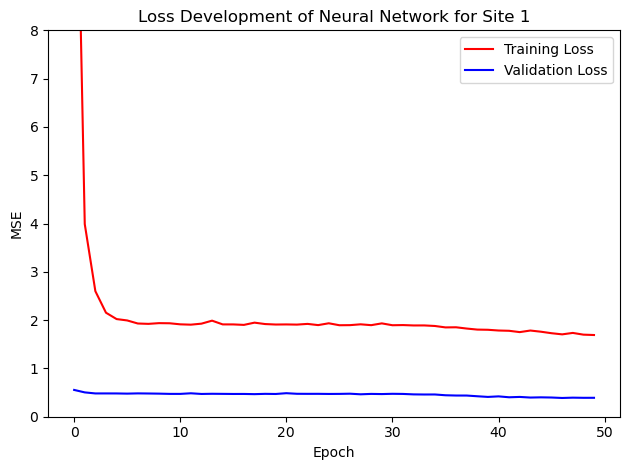

In [47]:
fig, ax1 = plt.subplots()
ax1.plot(loss_training_1, color='red', label='Training Loss')
ax1.plot(loss_validation_1, color='blue', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.set_ylim([0, 8])
ax1.legend()
plt.title("Loss Development of Neural Network for Site 1")
fig.tight_layout()
plt.savefig('../plots/loss_development_of_neural_network_for_site_1.png', dpi = 600)
plt.show()

We now repeat this process for the second site.

In [31]:
model_2 = SimpleNN().to(device)
epochs = 50
learning_rate = 0.002
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr = learning_rate)
loss_training_2, loss_validation_2 = train(model_2, train_dl_2, valid_dl_2, epochs, optimizer, loss_func)

	epoch	|	train loss	|	val loss
--------------------------------------------------------------
	1	|	7.4098		|	0.4245
--------------------------------------------------------------
	2	|	1.9518		|	0.3720
--------------------------------------------------------------
	3	|	1.4641		|	0.3606
--------------------------------------------------------------
	4	|	1.3542		|	0.3595
--------------------------------------------------------------
	5	|	1.3130		|	0.3594
--------------------------------------------------------------
	6	|	1.2963		|	0.3586
--------------------------------------------------------------
	7	|	1.2877		|	0.3588
--------------------------------------------------------------
	8	|	1.2871		|	0.3593
--------------------------------------------------------------
	9	|	1.2817		|	0.3588
--------------------------------------------------------------
	10	|	1.2805		|	0.3592
--------------------------------------------------------------
	11	|	1.2819		|	0.3602
--------------------------------

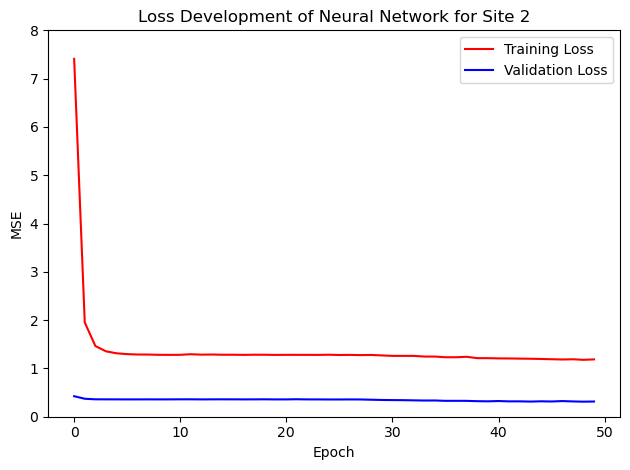

In [48]:
fig, ax1 = plt.subplots()
ax1.plot(loss_training_2, color='red', label='Training Loss')
ax1.plot(loss_validation_2, color='blue', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.set_ylim([0, 8])
ax1.legend()
plt.title("Loss Development of Neural Network for Site 2")
fig.tight_layout()
plt.savefig('../plots/loss_development_of_neural_network_for_site_2.png', dpi = 600)
plt.show()

With this function, we calculate the loss for the model on the testing set. This metric will be used to compare the performance of the neural network to the performance of the regression model.

In [33]:
def test(model, test_dl, loss_func):
    total_loss_test = 0
    model.eval()
    with torch.no_grad():
        for X_test, y_test in test_dl:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            preds = model(X_test)
            loss_test = loss_func(preds, y_test)
            total_loss_test = total_loss_test + loss_test.item()
    
    return total_loss_test

In [34]:
loss_func = nn.MSELoss()
loss_test_1 = test(model_1, test_dl_1, loss_func)
loss_test_2 = test(model_2, test_dl_2, loss_func)
print("Test loss 1st site:", loss_test_1)
print("Test loss 2nd site:", loss_test_2)

Test loss 1st site: 0.7438925472088158
Test loss 2nd site: 0.5867028483189642


### Linear Regression

Now that we know how the neural network performs, we set up a simple LinearRegressionModel in the same way. We define a LinearRegressionModel class, which includes only a single linear layer and is therefore very explainable.

In [35]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return torch.flatten(out)

In [36]:
model_reg_1 = LinearRegressionModel(8, 1).to(device)
epochs = 50
learning_rate = 0.001
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_reg_1.parameters(), lr = learning_rate)
loss_training_reg_1, loss_validation_reg_1 = train(model_reg_1, train_dl_1, valid_dl_1, epochs, optimizer, loss_func)

	epoch	|	train loss	|	val loss
--------------------------------------------------------------
	1	|	2.7211		|	0.5866
--------------------------------------------------------------
	2	|	2.2764		|	0.5110
--------------------------------------------------------------
	3	|	2.0410		|	0.4660
--------------------------------------------------------------
	4	|	1.8860		|	0.4454
--------------------------------------------------------------
	5	|	1.8276		|	0.4307
--------------------------------------------------------------
	6	|	1.7680		|	0.4248
--------------------------------------------------------------
	7	|	1.7573		|	0.4102
--------------------------------------------------------------
	8	|	1.7176		|	0.4097
--------------------------------------------------------------
	9	|	1.7519		|	0.4172
--------------------------------------------------------------
	10	|	1.7330		|	0.4080
--------------------------------------------------------------
	11	|	1.6946		|	0.4079
--------------------------------

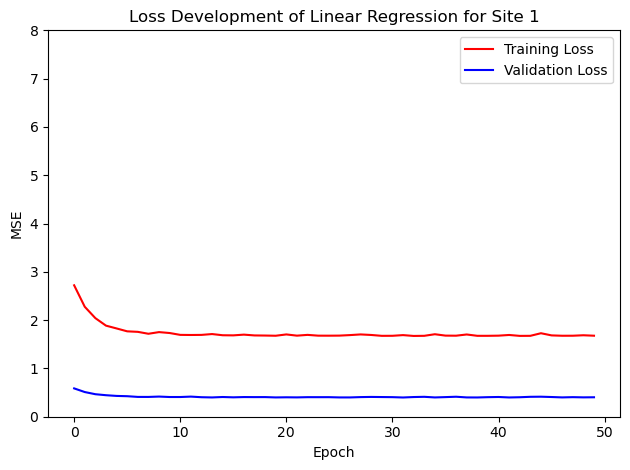

In [49]:
fig, ax1 = plt.subplots()
ax1.plot(loss_training_reg_1, color='red', label='Training Loss')
ax1.plot(loss_validation_reg_1, color='blue', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.set_ylim([0, 8])
ax1.legend()
plt.title("Loss Development of Linear Regression for Site 1")
fig.tight_layout()
plt.savefig('../plots/loss_development_of_linear_regression_for_site_1.png', dpi = 600)
plt.show()

In [38]:
model_reg_2 = LinearRegressionModel(8, 1).to(device)
epochs = 50
learning_rate = 0.001
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_reg_2.parameters(), lr = learning_rate)
loss_training_reg_2, loss_validation_reg_2 = train(model_reg_2, train_dl_2, valid_dl_2, epochs, optimizer, loss_func)

	epoch	|	train loss	|	val loss
--------------------------------------------------------------
	1	|	2.1137		|	0.4853
--------------------------------------------------------------
	2	|	1.5301		|	0.3913
--------------------------------------------------------------
	3	|	1.3156		|	0.3556
--------------------------------------------------------------
	4	|	1.2552		|	0.3434
--------------------------------------------------------------
	5	|	1.2262		|	0.3398
--------------------------------------------------------------
	6	|	1.2246		|	0.3386
--------------------------------------------------------------
	7	|	1.2198		|	0.3363
--------------------------------------------------------------
	8	|	1.2182		|	0.3380
--------------------------------------------------------------
	9	|	1.2158		|	0.3396
--------------------------------------------------------------
	10	|	1.2220		|	0.3366
--------------------------------------------------------------
	11	|	1.2192		|	0.3363
--------------------------------

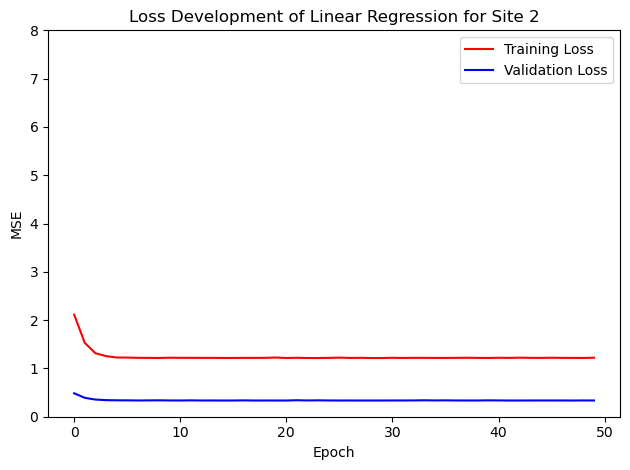

In [50]:
fig, ax1 = plt.subplots()
ax1.plot(loss_training_reg_2, color='red', label='Training Loss')
ax1.plot(loss_validation_reg_2, color='blue', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.set_ylim([0, 8])
ax1.legend()
plt.title("Loss Development of Linear Regression for Site 2")
fig.tight_layout()
plt.savefig('../plots/loss_development_of_linear_regression_for_site_2.png', dpi = 600)
plt.show()

In [40]:
loss_func = nn.MSELoss()
loss_test_reg_1 = test(model_reg_1, test_dl_1, loss_func)
loss_test_reg_2 = test(model_reg_2, test_dl_2, loss_func)
print("Neural network test loss 1st site:", loss_test_1)
print("Neural network test loss 2nd site:", loss_test_2)
print("*"*55)
print("Linear regression test loss 1st site:", loss_test_reg_1)
print("Linear regression test loss 2nd site:", loss_test_reg_2)

Neural network test loss 1st site: 0.7438925472088158
Neural network test loss 2nd site: 0.5867028483189642
*******************************************************
Linear regression test loss 1st site: 0.7366186701692641
Linear regression test loss 2nd site: 0.5790197253227234


### Polynomial Regression

As you can see, the performance of the linear regression model is very similar to the neural network, while being a lot simpler, faster, and more explainable. However, for the first site, the neural network slightly outperforms the linear model. Therefore, we also want to try out a Polynomial Regression model, which works exaxtly the same, except for the input being transformed by different magnitudes to allow to portray non-linear relationships between the input data and the prediction. This still results in a very interpretable model, and might boost the performance slightly.

We define a PolynomialRegressionModel in the same way as before. The model architecture does not change compared to the linear model, except for the number of input dimensions, because the input data is being input with different orders of magnitude.

In [41]:
class PolynomialRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolynomialRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim*5, output_dim)

    def forward(self, x):
        x_poly = torch.cat((x, torch.pow(x, 2), torch.pow(x, 3), torch.pow(x, 4), torch.pow(x, 5) ), dim=1)
                            #,torch.pow(x, 6), torch.pow(x, 7), torch.pow(x, 8), torch.pow(x, 9), torch.pow(x, 10)), dim=1)
        out = self.linear(x_poly)
        return torch.flatten(out)

In [42]:
model_reg_3 = PolynomialRegressionModel(8, 1).to(device)
epochs = 50
learning_rate = 0.001
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_reg_3.parameters(), lr = learning_rate)
loss_training_reg_3, loss_validation_reg_3 = train(model_reg_3, train_dl_1, valid_dl_1, epochs, optimizer, loss_func)

	epoch	|	train loss	|	val loss
--------------------------------------------------------------
	1	|	2.1753		|	0.4557
--------------------------------------------------------------
	2	|	1.7618		|	0.4425
--------------------------------------------------------------
	3	|	1.7525		|	0.4250
--------------------------------------------------------------
	4	|	1.7044		|	0.4195
--------------------------------------------------------------
	5	|	1.7185		|	0.4128
--------------------------------------------------------------
	6	|	1.7074		|	0.4135
--------------------------------------------------------------
	7	|	1.7153		|	0.4139
--------------------------------------------------------------
	8	|	1.6707		|	0.4028
--------------------------------------------------------------
	9	|	1.6727		|	0.4026
--------------------------------------------------------------
	10	|	1.6670		|	0.4034
--------------------------------------------------------------
	11	|	1.6646		|	0.4035
--------------------------------

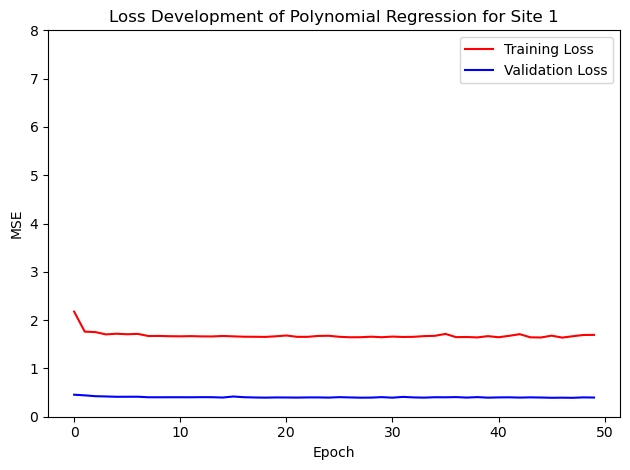

In [51]:
fig, ax1 = plt.subplots()
ax1.plot(loss_training_reg_3, color='red', label='Training Loss')
ax1.plot(loss_validation_reg_3, color='blue', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.set_ylim([0, 8])
ax1.legend()
plt.title("Loss Development of Polynomial Regression for Site 1")
fig.tight_layout()
plt.savefig('../plots/loss_development_of_polynomial_regression_for_site_1.png', dpi = 600)
plt.show()

In [44]:
model_reg_4 = PolynomialRegressionModel(8, 1).to(device)
epochs = 50
learning_rate = 0.001
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_reg_4.parameters(), lr = learning_rate)
loss_training_reg_4, loss_validation_reg_4 = train(model_reg_4, train_dl_2, valid_dl_2, epochs, optimizer, loss_func)

	epoch	|	train loss	|	val loss
--------------------------------------------------------------
	1	|	2.2447		|	0.4233
--------------------------------------------------------------
	2	|	1.3757		|	0.3680
--------------------------------------------------------------
	3	|	1.2816		|	0.3558
--------------------------------------------------------------
	4	|	1.2551		|	0.3480
--------------------------------------------------------------
	5	|	1.2394		|	0.3450
--------------------------------------------------------------
	6	|	1.2342		|	0.3460
--------------------------------------------------------------
	7	|	1.2212		|	0.3401
--------------------------------------------------------------
	8	|	1.2147		|	0.3381
--------------------------------------------------------------
	9	|	1.2080		|	0.3377
--------------------------------------------------------------
	10	|	1.2059		|	0.3373
--------------------------------------------------------------
	11	|	1.2024		|	0.3354
--------------------------------

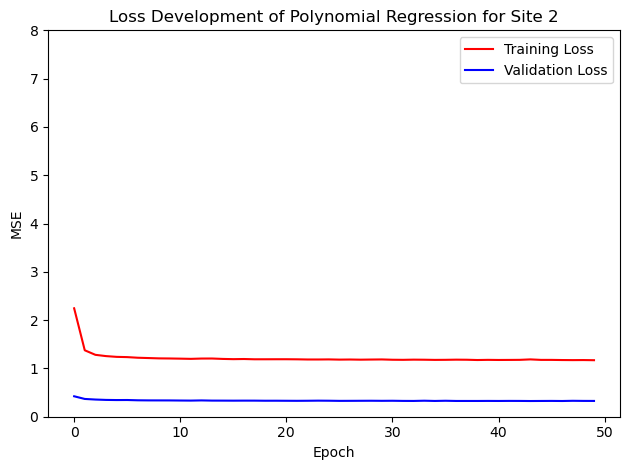

In [52]:
fig, ax1 = plt.subplots()
ax1.plot(loss_training_reg_4, color='red', label='Training Loss')
ax1.plot(loss_validation_reg_4, color='blue', label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('MSE')
ax1.set_ylim([0, 8])
ax1.legend()
plt.title("Loss Development of Polynomial Regression for Site 2")
fig.tight_layout()
plt.savefig('../plots/loss_development_of_polynomial_regression_for_site_2.png', dpi = 600)
plt.show()

In [53]:
loss_func = nn.MSELoss()
loss_test_reg_3 = test(model_reg_3, test_dl_1, loss_func)
loss_test_reg_4 = test(model_reg_4, test_dl_2, loss_func)
print("Neural network test loss 1st site:", loss_test_1)
print("Neural network test loss 2nd site:", loss_test_2)
print("*"*55)
print("Linear regression test loss 1st site:", loss_test_reg_1)
print("Linear regression test loss 2nd site:", loss_test_reg_2)
print("*"*55)
print("Polynomial regression test loss 1st site:", loss_test_reg_3)
print("Polynomial regression test loss 2nd site:", loss_test_reg_4)

Neural network test loss 1st site: 0.7438925472088158
Neural network test loss 2nd site: 0.5867028483189642
*******************************************************
Linear regression test loss 1st site: 0.7366186701692641
Linear regression test loss 2nd site: 0.5790197253227234
*******************************************************
Polynomial regression test loss 1st site: 0.7088572923094034
Polynomial regression test loss 2nd site: 0.6033891509287059


In [54]:
print("Neural network test loss 1st site:", loss_test_1)
print("Neural network test loss 2nd site:", loss_test_2)
print("*"*55)
print("Linear regression test loss 1st site:", loss_test_reg_1)
print("Linear regression test loss 2nd site:", loss_test_reg_2)

Neural network test loss 1st site: 0.7438925472088158
Neural network test loss 2nd site: 0.5867028483189642
*******************************************************
Linear regression test loss 1st site: 0.7366186701692641
Linear regression test loss 2nd site: 0.5790197253227234


So, the model performance seems to be very similar. Therefore, we will argue to employ the Linear Regression model, as it performs equally good and is the fastest, simplest and most easily explainable.

Let us print the weights of the linear regression, site 1:

In [58]:
feature_names = df_site_1.columns
weights = model_reg_1.linear.weight.data[0].cpu().numpy()

for feature, weight in zip(feature_names, weights):
    print(f'{feature}: {weight}')


connection_month: 0.0052874451503157616
connection_day: -0.003787705209106207
connection_hour: -0.24217194318771362
temperature: -0.014410912990570068
pressure: -0.004087554290890694
weather: 0.045620452612638474
windspeed: 0.036312393844127655
precipitation: -0.06425146758556366


Site 2:

In [59]:
feature_names = df_site_2.columns
weights = model_reg_2.linear.weight.data[0].cpu().numpy()

for feature, weight in zip(feature_names, weights):
    print(f'{feature}: {weight}')


connection_month: 0.023451903834939003
connection_day: 0.004659086000174284
connection_hour: -0.08461172878742218
temperature: -0.007080324459820986
pressure: -0.04800762981176376
weather: -0.0018498190911486745
windspeed: -0.044084955006837845
precipitation: -0.018877575173974037
